In [2]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

In [3]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

In [4]:
# load data
training_data = read_idx("./MNIST/train-images-ubyte/data")
training_labels = read_idx("./MNIST/train-labels-ubyte/data")
val_data = read_idx("./MNIST/t10k-images-idx3-ubyte/data")
val_labels = read_idx("./MNIST/t10k-labels-idx1-ubyte/data")

# print(training_data[2])

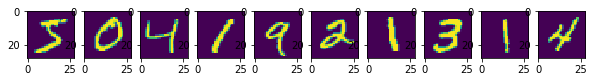

In [5]:
# plot data 
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    ax[i].imshow(training_data[i])

In [6]:
# reset graph
tf.reset_default_graph()

# Now we use the tf.data library to create a proper dataset that we can work with.
train_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
val_dataset = tf.data.Dataset.from_tensor_slices((val_data, val_labels))

# print(train_dataset)

# directly define batchsize we want to use.
train_batch_size = 128
val_batch_size = 10000
train_dataset = train_dataset.batch(train_batch_size)
val_dataset = val_dataset.batch(val_batch_size)

num_training = len(training_labels) # total number of training data
# Shuffle the training data in each epoch.
train_dataset = train_dataset.shuffle(buffer_size=num_training, reshuffle_each_iteration=True)

In [7]:
# Iterator
iterator = tf.data.Iterator.from_structure(train_dataset.output_types,
                                           train_dataset.output_shapes)

# print(train_dataset.output_shapes) # 1st is image, 2nd is label

# method that returns always the next element from the iterator.
next_batch = iterator.get_next()

# 2 initializer operations
train_init_op = iterator.make_initializer(train_dataset)
val_init_op = iterator.make_initializer(val_dataset)


In [11]:
# next_batch returns img & label
input_data = next_batch[0]
labels = next_batch[1]

input_data = tf.reshape(input_data,shape=[-1,784]) #flattening the img 
input_data = tf.cast(input_data, tf.float32)

labels_hot = tf.one_hot(labels, 10)

# print(training_data.shape)

# num class labels
nc = len(np.unique(training_labels))

# MODEL
# random weights
W = tf.Variable(tf.random_normal([784, nc],stddev=2e-06))
# biases 0 val. 
B = tf.Variable(tf.zeros([1,10]))
# print("W, B : {} {}".format(W, B))

# drive of last layer
logit = tf.matmul(input_data,W) + B 
# softmax output 
out = tf.nn.softmax(logit)
# print("Logit : {}".format(logit))
# print("Labels :{}".format(labels_hot))
# print("Input : {}".format(input_data))

# the index of most likely class based on our model
prediction = tf.cast(tf.argmax(input=out, axis=1), tf.float32)

# convert labels to int to compare w/ predictions
labels = tf.cast(labels, tf.float32) 
print(labels)
# correct predictions, 1 or 0 bool casted to float32
correct = tf.cast((tf.equal(prediction, labels)), tf.float32) 
print(correct)
print("label {}".format(labels))
print(prediction)

# accuracy, mean val. of correct
percent_correct = tf.reduce_mean(correct) 
print(percent_correct)

Tensor("Cast_14:0", shape=(?,), dtype=float32)
Tensor("Cast_15:0", shape=(?,), dtype=float32)
label Tensor("Cast_14:0", shape=(?,), dtype=float32)
Tensor("Cast_13:0", shape=(?,), dtype=float32)
Tensor("Mean_3:0", shape=(), dtype=float32)


In [8]:
# cross entropy loss
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(dim=-1, 
                                                           logits=logit,labels=labels_hot) 
print("Cross entropy : {}".format(cross_entropy))

# our loss as mean of cross entropy for all data 
loss = tf.reduce_mean(cross_entropy)
print(loss)

Cross entropy : Tensor("softmax_cross_entropy_with_logits/Reshape_2:0", shape=(?,), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32)


In [9]:
# optimizer 

#learning rate
a = 1e-5

optimizer = tf.train.GradientDescentOptimizer(learning_rate=a)
training_step = optimizer.minimize(loss, var_list=W) # need var_list = W here ? 

In [10]:
# summaries

tf.summary.scalar('loss', loss)
tf.summary.scalar('accuracy', percent_correct)
mergesum = tf.summary.merge_all()

t_write = tf.summary.FileWriter('./summaries/train')
v_write = tf.summary.FileWriter('./summaries/validation',flush_secs=2)

In [11]:
# TRAINING
epochs = 5

with tf.Session() as sess:
    
    # initialize the variables.
    sess.run(tf.global_variables_initializer())
    global_step = 0
    
    # loop through epochs
    for _ in range(epochs):
        
        # Load the training data into the iterator.
        sess.run(train_init_op)
        
        # In each epoch we want to go through all batches of the training data. 
        while True:
            try:
                _, summary  = sess.run((training_step, mergesum))
                # We write the summary into our folder.
                t_write.add_summary(summary, global_step)

                global_step += 1
                
            # Breakout of the loop if we looked at all batches
            except tf.errors.OutOfRangeError:
                break
            
    # VALIDATION

    # Load the validation data into the iterator.
    sess.run(val_init_op)
    summary = sess.run((mergesum))
    v_write.add_summary(summary, global_step)
    